In [8]:
import pandas as pd

# CSV-Datei einlesen
df = pd.read_csv("rel_gemeinde.csv")
df.columns = df.columns.str.strip()

# Originalgruppen → saubere Bezeichnungen
mapping = {
    'mehrheit reformiert: ≥ 80,0 %': 'Stark Reformiert',
    'mehrheit reformiert: 60,0 - 79,9 %': 'Überwiegend Reformiert',
    'mehrheit reformiert: 40,0 - 59,9 %': 'Eher Reformiert',
    'mehrheit katholisch: 40,0 - 59,9 %': 'Eher Katholisch',
    'mehrheit katholisch: 60,0 - 79,9 %': 'Überwiegend Katholisch',
    'mehrheit katholisch: ≥ 80,0 %': 'Stark Katholisch',
    'mehrheit mit anderer oder ohne religionszugehörigkeit: 40,0 - 59,9 %': 'Divers'
}


# Sichere Gruppenzuweisung
def map_religionsgruppe(text):
    if pd.isna(text):
        return "Unbekannt"
    return mapping.get(text.strip().lower(), "Unbekannt")


# Stabiler Modus: alphabetisch bei Gleichstand
def stabiler_modus(gruppen):
    counts = gruppen.value_counts()
    max_count = counts.max()
    top_values = counts[counts == max_count].index.tolist()
    return sorted(top_values)[0]

# Alle Jahrgangsspalten bestimmen
jahr_spalten = [col for col in df.columns if col.startswith("y_")]

# Neues Ergebnis-DataFrame
result_modus = pd.DataFrame()

# Modus pro Kanton & Jahr berechnen
result_modus = pd.DataFrame()

for jahr in jahr_spalten:
    jahrzahl = int(jahr.replace("y_", ""))  # z. B. 'y_1850' → 1850
    df_tmp = df[["Kanton", jahr]].copy()
    df_tmp["Gruppe"] = df_tmp[jahr].apply(map_religionsgruppe)

    # Sonderregel: JU vor 1980 → Divers
    if jahrzahl < 1980:
        df_tmp.loc[df_tmp["Kanton"] == "JU", "Gruppe"] = "Divers"

    # Nur gültige Gruppen berücksichtigen
    df_valid = df_tmp[df_tmp["Gruppe"] != "Unbekannt"].copy()

    # Modus pro Kanton
    kanton_result = (
        df_valid
        .groupby("Kanton")["Gruppe"]
        .agg(stabiler_modus)
        .reset_index()
        .rename(columns={"Gruppe": jahr})
    )

    if result_modus.empty:
        result_modus = kanton_result
    else:
        result_modus = pd.merge(result_modus, kanton_result, on="Kanton")

# Manuelle Daten für GL (Glarus), aus externem Code berechnet
manuelle_werte_gl = [
    'Mehrheit reformiert: ≥ 80,0 %',  # y_1850
    'Mehrheit reformiert: ≥ 80,0 %',  # y_1860
    'Mehrheit reformiert: ≥ 80,0 %',  # y_1870
    'Mehrheit reformiert: ≥ 80,0 %',  # y_1880
    'Mehrheit Reformiert: ≥ 80,0 %',  # y_1890
    'Mehrheit reformiert: ≥ 80,0 %',  # y_1900
    'Mehrheit reformiert: ≥ 80,0 %',  # y_1910
    'Mehrheit reformiert: ≥ 80,0 %',  # y_1920
    'Mehrheit reformiert: ≥ 80,0 %',  # y_1930
    'Mehrheit reformiert: ≥ 80,0 %',  # y_1940
    'Mehrheit reformiert: 60,0 - 79,9 %',  # y_1950
    'Mehrheit reformiert: 60,0 - 79,9 %',  # y_1960
    'Mehrheit reformiert: 60,0 - 79,9 %',  # y_1970
    'Mehrheit reformiert: 60,0 - 79,9 %',  # y_1980
    'Mehrheit reformiert: 40,0 - 59,9 %',  # y_1990
    'Mehrheit reformiert: 40,0 - 59,9 %',  # y_2000
    'Mehrheit reformiert: 40,0 - 59,9 %',  # y_2014
]

# Map auf deine offizielle Gruppenzuordnung
manuelle_gruppen_gl = [map_religionsgruppe(val) for val in manuelle_werte_gl]

# Spaltenreihenfolge wie im Ergebnis
spalten = ['Kanton'] + jahr_spalten[:len(manuelle_gruppen_gl)]

# Zusammenbauen der DataFrame-Zeile für GL
gl_eintrag = pd.DataFrame([['GL'] + manuelle_gruppen_gl], columns=spalten)

# GL ergänzen, falls nicht vorhanden
if 'GL' not in result_modus["Kanton"].values:
    result_modus = pd.concat([result_modus, gl_eintrag], ignore_index=True)



# Speichern in CSV-Datei
result_modus.to_csv("religionsgruppen_pro_kanton.csv", index=False)
print("Datei 'religionsgruppen_pro_kanton.csv' wurde erfolgreich erstellt.")


Datei 'religionsgruppen_pro_kanton.csv' wurde erfolgreich erstellt.


/var/folders/pb/dkv6sff91j996kpc90tk4j0m0000gn/T/ipykernel_1706/1208101752.py:34: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  matrix = df_heatmap.applymap(lambda x: kategorie_to_int.get(x, -1)).values


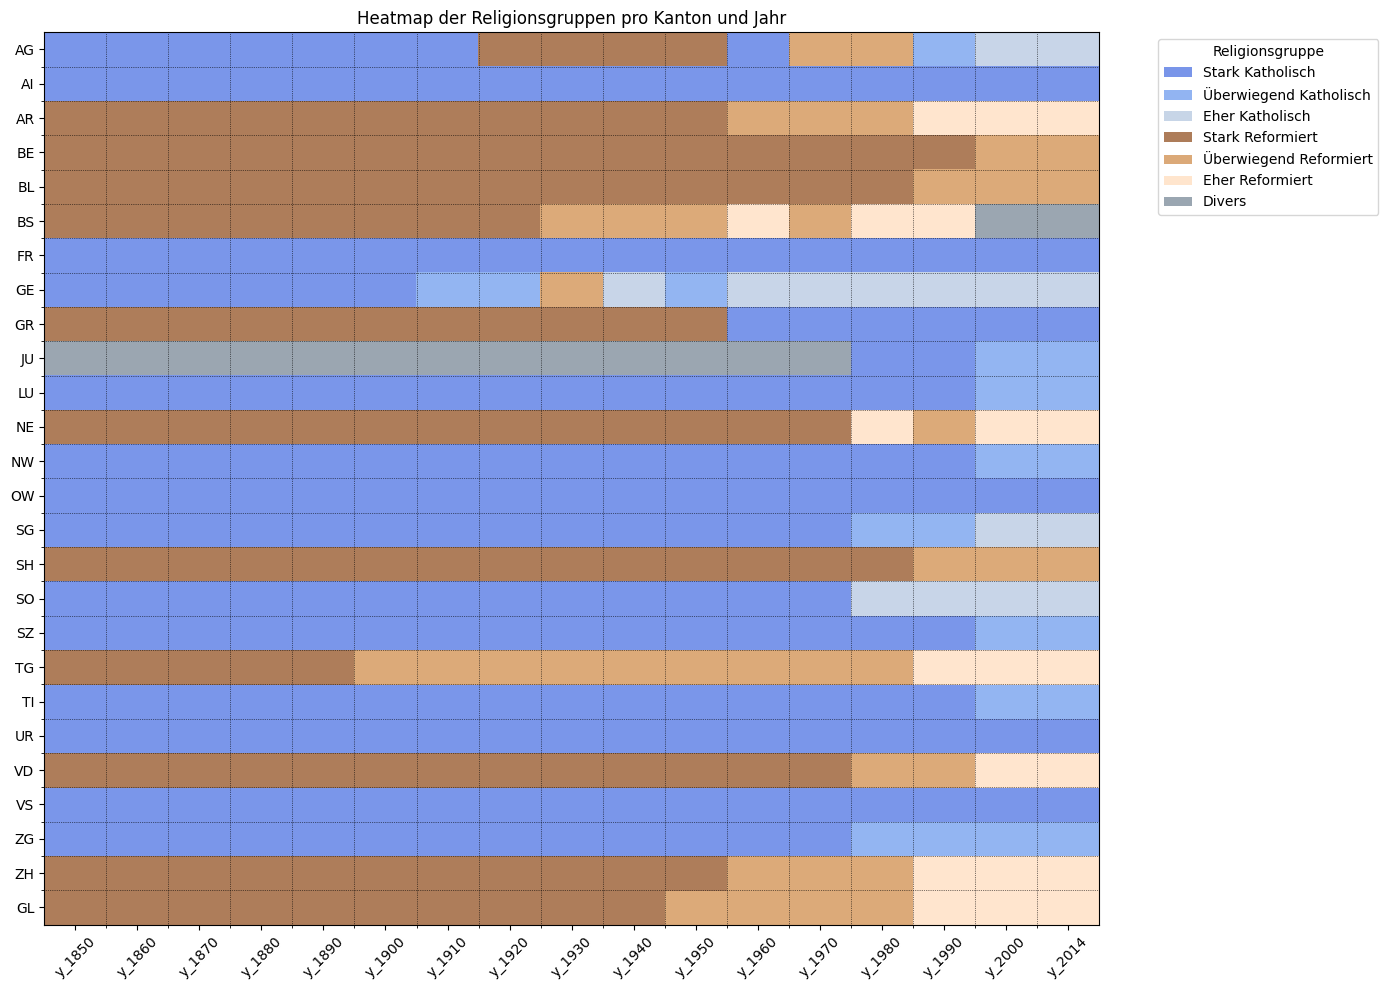

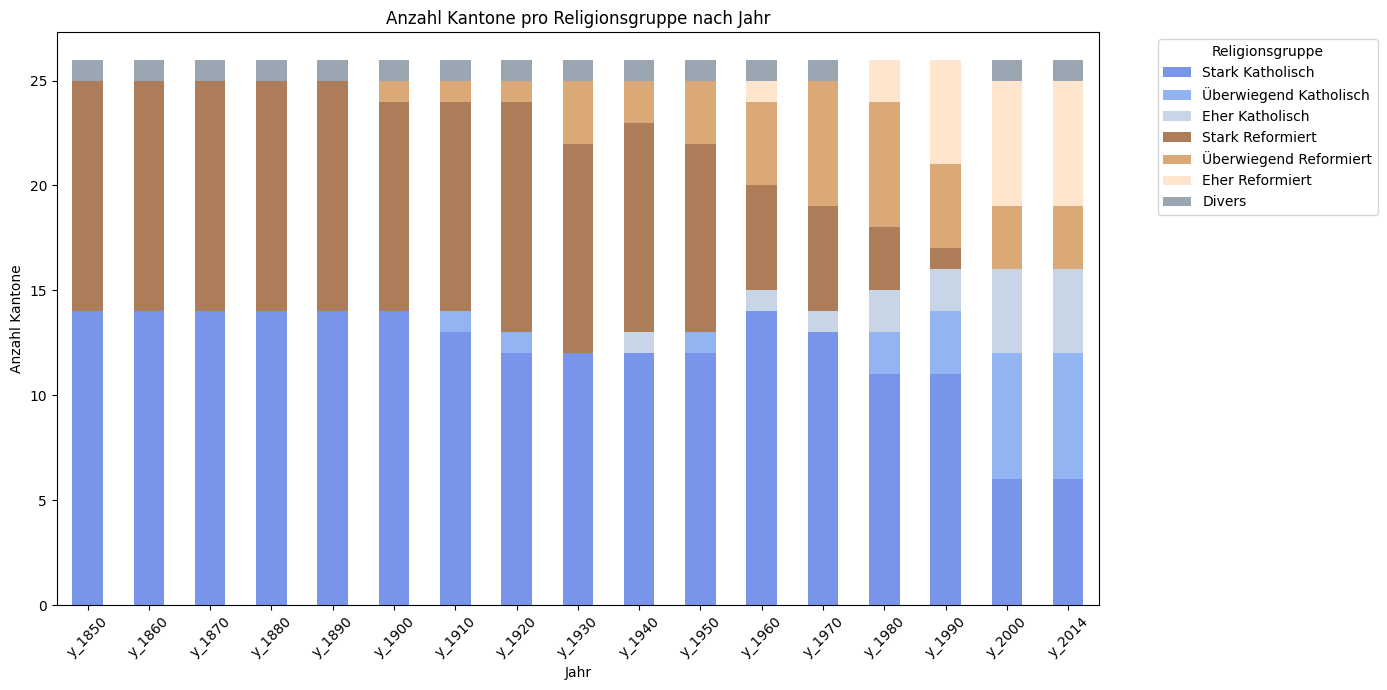

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

# CSV-Datei laden
df_plot = pd.read_csv("religionsgruppen_pro_kanton.csv")

# Farbdefinition
farben = {
    'Stark Katholisch': 'royalblue',
    'Überwiegend Katholisch': 'cornflowerblue',
    'Eher Katholisch': 'lightsteelblue',
    'Stark Reformiert': 'saddlebrown',
    'Überwiegend Reformiert': 'peru',
    'Eher Reformiert': 'peachpuff',
    'Divers': 'slategrey'
}

alpha = 0.7  # Transparenz

# Gruppennamen in fixer Reihenfolge
kategorien = list(farben.keys())
kategorie_to_int = {k: i for i, k in enumerate(kategorien)}
farbenliste = [farben[k] for k in kategorien]

# ------------------------------------------
# HEATMAP: Kantonale Religionsgruppen
# ------------------------------------------

# Daten vorbereiten
df_heatmap = df_plot.set_index("Kanton")
jahre = df_heatmap.columns.tolist()
matrix = df_heatmap.applymap(lambda x: kategorie_to_int.get(x, -1)).values

# Plot erstellen
fig, ax = plt.subplots(figsize=(14, 10))
im = ax.imshow(matrix, aspect='auto', cmap=mcolors.ListedColormap(farbenliste), alpha=alpha)

# Achsen & Beschriftungen
ax.set_yticks(range(len(df_heatmap.index)))
ax.set_yticklabels(df_heatmap.index)
ax.set_xticks(range(len(jahre)))
ax.set_xticklabels(jahre, rotation=45)
ax.set_title("Heatmap der Religionsgruppen pro Kanton und Jahr")

# Grid aktivieren
ax.set_xticks([x - 0.5 for x in range(1, len(jahre))], minor=True)
ax.set_yticks([y - 0.5 for y in range(1, len(df_heatmap))], minor=True)
ax.grid(which="minor", color="black", linestyle=":", linewidth=0.5)

# Legende wie im Barplot
legende_patches = [Patch(facecolor=farben[k], label=k, alpha=alpha) for k in kategorien]
ax.legend(handles=legende_patches, title="Religionsgruppe", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# ------------------------------------------
# BARPLOT: Anzahl Kantone pro Gruppe & Jahr
# ------------------------------------------

# Daten aufbereiten für Barplot
df_melt = df_plot.melt(id_vars="Kanton", var_name="Jahr", value_name="Gruppe")
df_counts = df_melt.groupby(["Jahr", "Gruppe"]).size().unstack(fill_value=0)[kategorien]

# Barplot zeichnen
df_counts.plot(
    kind="bar",
    stacked=True,
    color=[farben[k] for k in kategorien],
    alpha=alpha,
    figsize=(14, 7)
)
plt.title("Anzahl Kantone pro Religionsgruppe nach Jahr")
plt.ylabel("Anzahl Kantone")
plt.xticks(rotation=45)
plt.legend(title="Religionsgruppe", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
